In [1]:
import os

# Set the environment variable
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [14]:
import torch
from sbi.inference import SNLE
import matplotlib.pyplot as plt

# Inverse gaussian

## generate theta and x

In [3]:
N = int(50e3)
# theta
alphas = torch.distributions.Uniform(0.1, 3.0).sample((N,))
betas = torch.distributions.Uniform(0.1, 3.0).sample((N,))
theta = torch.stack((alphas, betas), dim=1)
print(f'theta shape: {theta.shape}')

# x
x = torch.zeros(N, 1)
for i in range(N):
    alpha, beta = theta[i]
    gamma_dist = torch.distributions.Gamma(concentration=alpha, rate=1/beta)  #'rate' = 1/scale
    x[i] = gamma_dist.sample((1,))

print(f'x shape: {x.shape}')

theta shape: torch.Size([50000, 2])
x shape: torch.Size([50000, 1])


## SNLE

In [23]:
inference = SNLE(density_estimator='nsf')
likelihood_estimator = inference.append_simulations(theta, x).train()


 Neural network successfully converged after 101 epochs.

## test likelihood

In [29]:
N_test = int(10e3)
x_test = torch.linspace(-4,4, N_test).reshape(1, -1)
theta_test = torch.stack((torch.ones(N_test), torch.ones(N_test)), dim=1)
print(f'theta_test shape: {theta_test.shape}')
print(f'x_test shape: {x_test.shape}')

loglike = likelihood_estimator.log_prob(x_test, theta_test)
print(f'loglike shape: {loglike.shape}')

theta_test shape: torch.Size([10000, 2])
x_test shape: torch.Size([1, 10000])
loglike shape: torch.Size([1, 10000])


## sampled

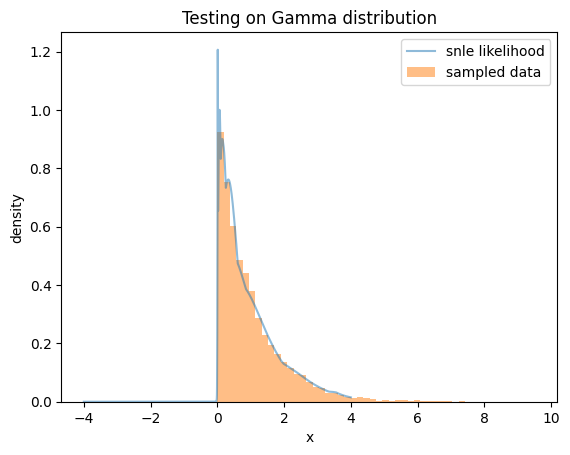

In [30]:
# generate data from theta_test
x_test_gen = torch.zeros(N_test, 1)
for i in range(N_test):
    alpha, beta = theta_test[i]
    gamma_dist = torch.distributions.Gamma(concentration=alpha, rate=1/beta)  # PyTorch uses 'rate' = 1/scale
    x_test_gen[i] = gamma_dist.sample((1,))
    
plt.plot(x_test.squeeze().detach().numpy(), loglike.exp().squeeze().detach().numpy(), label='snle likelihood', alpha=0.5);
plt.hist(x_test_gen.squeeze().detach().numpy(), bins=50, density=True, alpha=0.5, label='sampled data');
plt.xlabel('x')
plt.ylabel('density')
plt.legend();
plt.title('Testing on Gamma distribution');